# LSV Data Analysis and Parameter Estimation  

##### First, all relevent Python packages are imported

In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
import pandas as pd
import math
import glob
import altair as alt

from voltammetry import preprocessing, plotting, fitting

##### The user will be able to import experimental data for an LSV scan 
##### (Currently, we assume that the LSV sweep starts at equilibrium)

In [34]:
##Import Experimental Reversible Data:
    
rev_exp_data = pd.read_csv("data/10mVs_Reversible.csv")
current_exp=rev_exp_data['current(A)'].values
voltage_exp=rev_exp_data['voltage(mV)'].values
time_exp=rev_exp_data['time(s)'].values


## all appropriate packages and the singular experimental data file is imported now


##### Next, the program will grab some simple quantitative information from the graph that may be hard to do by hand or over extensive datasets

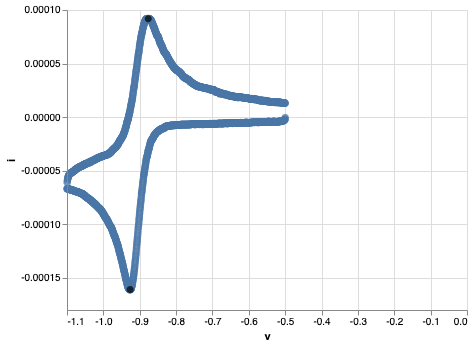

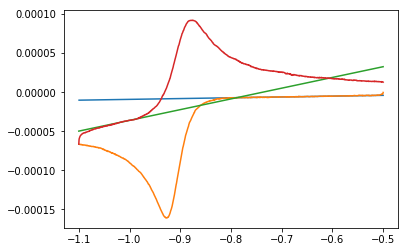

In [35]:
t,i,v = preprocessing.readFile('data/10mM_F2CA_1M_KOH_pH_14_100mV.DTA',type='gamry',scan='first')
length = len(t)
v1, v2 = v[0:int(length/2)], v[int(length/2):]
i1, i2 = i[0:int(length/2)], i[int(length/2):]
t1, t2 = t[0:int(length/2)], t[int(length/2):]

peak_list = []

_, v_peaks, i_peaks = fitting.peak_find(v1,i1,v2,i2)
b1, b2 = fitting.baseline(v1,i1,v2,i2)

for n in range(len(v_peaks)):

    peak_list.append([i_peaks[n],v_peaks[n]])



plotting.plot_voltammogram(t,i,v, peaks = peak_list).display()

plt.plot(v1,b1)
plt.plot(v1,i1)
plt.plot(v2,b2)
plt.plot(v2,i2)

##### This program can also return relevant parameters using a physics-based model.

What is the Voltage sweep rate in mV/s?(10) 10
What is the electrode surface area in cm^2?(.2) .2
What is the initial concentration in mol/cm^3?(.00001) .00001
What is the temperature in K?(298) 298
What is the equilibrium potential in V?(.10) .10


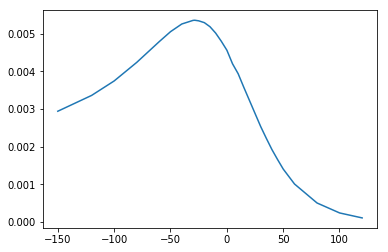

In [28]:
# Import the dimensionless voltammagram (V I) for reversible reactions

rev_dim_values = pd.read_csv("data/dimensionless_values_rev.csv")
rev_dim_current=rev_dim_values['dimensionless_current'].values
rev_dim_voltage=rev_dim_values['dimensionless_Voltage'].values

##We will now prompt the user to submit known parameters (THESE CAN BE CHANGED OR MADE MORE CONVENIENT)
sweep_rate= float(input("What is the Voltage sweep rate in mV/s?(10)"))
electrode_surface_area= float(input("What is the electrode surface area in cm^2?(.2)"))
concentration_initial= float(input("What is the initial concentration in mol/cm^3?(.00001)"))
Temp= float(input("What is the temperature in K?(298)"))
eq_pot= float(input("What is the equilibrium potential in V?(.10)"))

##we are inserting a diffusion coefficient to check math here, we will estimate this later:
Diff_coeff=0.00001

## Here we define constant variables, these can be made to user inputs if needed.
n=1
Faradays_const=96285
R_const=8.314
sigma=(n*Faradays_const*sweep_rate)/(R_const*Temp)
Pre=electrode_surface_area*concentration_initial*n*Faradays_const*math.sqrt(Diff_coeff*sigma)



output_voltage=(eq_pot+rev_dim_voltage/n)
output_current=Pre*rev_dim_current

plt.plot(output_voltage,output_current)



##### Then, we can back out a relevant parameter from the data:

In [22]:
# Fitting Diff_Coeff

def test_func(rev_dim_current, D):
    return electrode_surface_area*concentration_initial*n*Faradays_const*math.sqrt(D*sigma)*rev_dim_current

params, params_covariance = curve_fit(test_func, rev_dim_current, output_current,p0=None,bounds = (0,[1]))

print("Diffusion Coefficient (cm^2/s): {}".format(params[0]))

Diffusion Coefficient (cm^2/s): 1.0000011458318317e-05


##### We can repeat this exercise on an LSV with an irreversible reaction to determine exchange current density.

In [23]:
##Import Experimental Irreversible Data:
    
irrev_exp_data = pd.read_csv("data/10mVs_Irreversible.csv")
current_exp=irrev_exp_data['current(A)'].values
voltage_exp=irrev_exp_data['voltage(mV)'].values
time_exp=irrev_exp_data['time(s)'].values

## all appropriate packages and the singular experimental data file is imported now

In [24]:
# Import the dimensionless voltammagram (V I) for irreversible reactions

irrev_dim_values = pd.read_csv("data/dimensionless_values_irrev.csv")
irrev_dim_current=irrev_dim_values['dimensionless_current'].values
irrev_dim_voltage=irrev_dim_values['dimensionless_Voltage'].values

What is the Voltage sweep rate in mV/s?(10) 10
What is the electrode surface area in cm^2?(.2) .2
What is the initial concentration in mol/cm^3?(.00001) .00001
What is the temperature in K?(298) 298
What is the equilibrium potential in mV?(100) 100


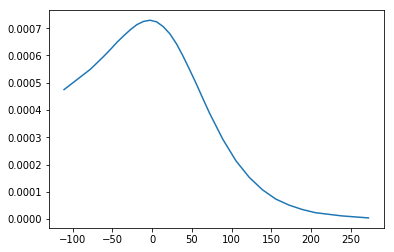

In [29]:
##We will now prompt the user to submit known parameters (THESE CAN BE CHANGED OR MADE MORE CONVENIENT)
sweep_rate= float(input("What is the Voltage sweep rate in mV/s?(10)"))
electrode_surface_area= float(input("What is the electrode surface area in cm^2?(.2)"))
concentration_initial= float(input("What is the initial concentration in mol/cm^3?(.00001)"))
Temp= float(input("What is the temperature in K?(298)"))
eq_pot= float(input("What is the equilibrium potential in mV?(100)"))

##we are inserting a diffusion coefficient to check math here, we will estimate this later:
Diff_coeff=0.00001

## Here we define constant variables, these can be made to user inputs if needed.
n=1
Faradays_const=96285
R_const=8.314
exchange_current_density=0.0002
kinetic_coefficient=exchange_current_density/n/Faradays_const/electrode_surface_area/concentration_initial
transfer_coefficient=.6
eV_const=59.1


beta=transfer_coefficient*n*Faradays_const*sweep_rate/R_const/Temp/1000
Pre=(concentration_initial*n*Faradays_const*
    math.sqrt(Diff_coeff*sweep_rate*transfer_coefficient
    *Faradays_const/(R_const*Temp*1000)))



output_voltage=eq_pot+irrev_dim_voltage/transfer_coefficient-eV_const/transfer_coefficient*math.log(math.sqrt(math.pi*Diff_coeff*beta)/kinetic_coefficient)
output_current=Pre*irrev_dim_current

plt.plot(output_voltage,output_current)




In [31]:
# Fitting Diff_Coeff
from scipy import optimize


def test_func(irrev_dim_voltage, exchange_current_density):
    return eq_pot+irrev_dim_voltage/transfer_coefficient-eV_const/transfer_coefficient*math.log(math.sqrt(math.pi*Diff_coeff*beta)/(exchange_current_density/n/Faradays_const/electrode_surface_area/concentration_initial))

params, params_covariance = optimize.curve_fit(test_func, irrev_dim_voltage, output_voltage,p0=None,bounds = (0,[1]))

print("Exchange current density (A/cm^2): {}".format(params[0]))

Exchange current density (A/cm^2): 0.00020000000000000006
